Poupouse of this noebook is to test combination of different transroms to understand what....

In [23]:
import numpy as np
import scipy as sp
import pandas as pd

# Preprocessing libraries
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler, QuantileTransformer, PowerTransformer, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor

from sklearn.decomposition import PCA

# Modeling libraries
from sklearn.model_selection import RandomizedSearchCV, KFold,RepeatedKFold, ShuffleSplit, cross_validate, cross_val_predict, cross_val_score, train_test_split, StratifiedKFold

# Modeling libraries
from sklearn.linear_model import LinearRegression, LassoCV



In [32]:
from pathlib import Path
from src.clean import clean

# Read data
data_dir = Path("/home/reinis/Documents/House Prices - Advanced Regression Techniques/notebooks/data")
train_df = pd.read_csv(data_dir / "train.csv")
dfx, label = clean(train_df)

In [25]:
#redefine subsets according to preprocessing needs
discrete = ['YearBuilt', 'YearRemodAdd','BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
            'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd','Fireplaces', 'GarageYrBlt','GarageCars', 
            'MoSold', 'YrSold', 'OverallQual', 'OverallCond']

continuous = ['LotFrontage', 'LotArea','MasVnrArea','BsmtFinSF1',  'BsmtFinSF2', 'BsmtUnfSF', 
              'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea', 'GarageArea',  
              'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch', 'PoolArea', 
              'MiscVal']

nominal = ['MSSubClass','MSZoning', 'Street', 'Alley',  'LandContour','LotConfig',   'Neighborhood', 
           'Condition1', 'Condition2', 'BldgType', 'HouseStyle','RoofStyle','RoofMatl', 'Exterior1st',
           'Exterior2nd', 'MasVnrType',  'Foundation','Heating',  'CentralAir',  'GarageType','MiscFeature',
           'SaleType', 'SaleCondition']

ordinal = ['LotShape', 'LandSlope', 'Utilities',   'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
           'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','HeatingQC', 'Electrical','KitchenQual', 
           'Functional','FireplaceQu', 'GarageFinish', 'GarageQual','GarageCond','PavedDrive', 
           'PoolQC', 'Fence']

# arrange categorical variable in categorical order to improve performance of linear models
LotShape = ['Reg', 'IR1', 'IR2', 'IR3']
LandSlope = ['Gtl', 'Mod', 'Sev']
Utilities = ['AllPub', 'NoSewr', 'NoSeWa', 'ELO']
ExterQual = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
ExterCond = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
BsmtQual = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
BsmtCond = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
BsmtExposure = ['Gd', 'Av', 'Mn', 'No', 'NA']
BsmtFinType1 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
BsmtFinType2 = ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA']
HeatingQC = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
Electrical = ['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix']
KitchenQual = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
Functional = ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal']
FireplaceQu = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
GarageFinish = ['Fin', 'RFn', 'Unf', 'NA']
GarageQual = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
GarageCond = ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA']
PavedDrive = ['Y', 'P', 'NA']
PoolQC = ['Ex', 'Gd', 'TA', 'Fa', 'NA']
Fence = ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA']

categories = [LotShape, LandSlope, Utilities, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, 
              BsmtFinType1, BsmtFinType2, HeatingQC, Electrical, KitchenQual, Functional, FireplaceQu, 
              GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence]

ply = ['BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']

In [26]:
polynomial_features = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0, add_indicator=True), 
    RobustScaler(),
    PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False)
)
num_cont_processor = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0, add_indicator=True), 
    RobustScaler(),
    PowerTransformer(method='yeo-johnson')
    
)

num_disc_processor = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0, add_indicator=True), 
    RobustScaler()
)

cat_ord_tree_processor = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OrdinalEncoder(
        categories=categories,
        handle_unknown="use_encoded_value",
        unknown_value=-2,
        encoded_missing_value=-1
        ),
    MinMaxScaler(feature_range=(0, 1)),
)

cat_ohe_tree_processor = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='No'),
    OneHotEncoder(
        handle_unknown='infrequent_if_exist',
        drop='first'
    ),
)

preprocessor = make_column_transformer(
    (polynomial_features, ply),
    (num_cont_processor, continuous), 
    (num_disc_processor, discrete),
    (cat_ord_tree_processor, ordinal),
    (cat_ohe_tree_processor, nominal)
)

In [27]:
from src.preprocessor_test import preprocessor_test

stacking_regressor = preprocessor_test(preprocessor)
stacking_regressor

StackingRegressor(estimators=[('ridge',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline-1',
                                                                                 Pipeline(steps=[('simpleimputer',
                                                                                                  SimpleImputer(add_indicator=True,
                                                                                                                fill_value=0,
                                                                                                                strategy='constant')),
                                                                                                 ('robustscaler',
                                                                                                  RobustScaler()),
                                                                                                 ('polynomialfeatures',
                                                                                                  PolynomialFeatures(include_bias=False))]),
                                                                                 ['BsmtFinSF1',
                                                                                  'TotalBsmtSF',
                                                                                  '1s...
                                                                                  'Heating',
                                                                                  'CentralAir',
                                                                                  'GarageType',
                                                                                  'MiscFeature',
                                                                                  'SaleType',
                                                                                  'SaleCondition'])])),
                                               ('transformedtargetregressor',
                                                TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                           inverse_func=<ufunc 'expm1'>,
                                                                           regressor=RandomForestRegressor()))]))],
                  final_estimator=ElasticNetCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                                               l1_ratio=[0.1, 0.4, 0.5, 0.55,
                                                         0.6, 0.7, 0.9, 0.95,
                                                         0.99, 1]))

In [28]:
score = cross_val_score(
                stacking_regressor, 
                dfx, 
                label,
                scoring='neg_mean_absolute_error',
                cv=2,
                n_jobs=-1
                )
-score.mean()

/home/reinis/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [8, 12, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/reinis/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [12, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/reinis/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [20, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/reinis/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [13, 17, 20, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/reinis/.local/lib/python3.10/site-packa

13549.640673675469

/home/reinis/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [20, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/reinis/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 8, 13, 14, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/reinis/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [12, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/reinis/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [8, 11, 12, 13, 16, 20, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/reinis/.local/lib/pyt

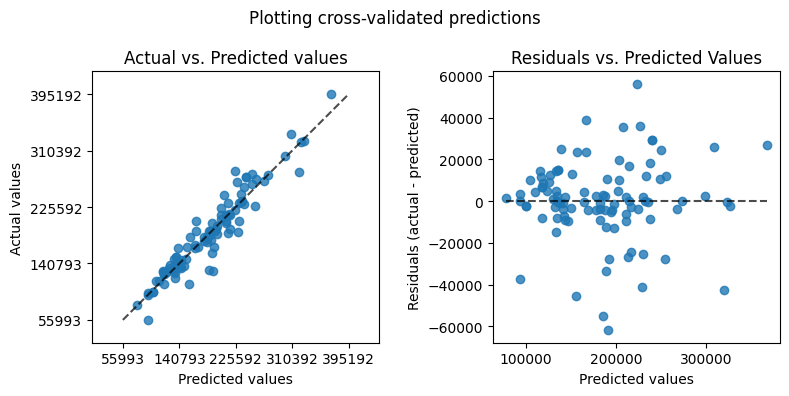

In [29]:
from src.plots.residual_plot import residual_plot
residual_plot(stacking_regressor,dfx,label)

In this analysis, it was found that there is a relationship between the residuals and the fitted values of the model. This is an indication that the model is not correctly capturing the variance in the data, which can lead to inaccuracies in predictions. The residual plot also shows clear heteroskedasticity, meaning that the variance of the residuals is not constant across all levels of the fitted values.

One possible explanation for this is that the model is not accounting for important variables or interactions that are present in the data. Another possibility is that the model is too complex and is fitting to noise in the data rather than the underlying relationship.

To address this issue, there are several things that can be done. One approach would be to try a different model that is better suited for the data, such as a non-linear model or a model that accounts for interactions between variables. Another approach would be to perform feature selection to identify which variables are most important for the model and remove any that are not contributing to the predictions.

Another approach would be to use a technique called weighted least squares, which gives more weight to the observations with higher variance, this helps to balance the residuals.

Additionally, it could be done by transforming the independent variables or the dependent variable, such as taking the logarithm of the dependent variable or adding polynomial terms to the independent variables.

In summary, the presence of a relationship between the residuals and the fitted values and heteroscedasticity in residual plot suggests that the model is not correctly capturing the variance in the data. To address this issue, various techniques such as performing feature selection and introducing polynomial features can be implemented.

In [30]:
x_labels = []
mses_dataset = np.zeros(5)
stds_dataset = np.zeros(5)

In [31]:
from src.scoring.get_score import get_score

i = 0
mses_dataset[i], stds_dataset[i] = get_score(stacking_regressor, dfx, label)
x_labels.append("all")

/home/reinis/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [8, 14, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/reinis/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [20, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/reinis/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [8, 13, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/reinis/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [8, 13, 16, 20, 21] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/reinis/.local/lib/python3.10/site

KeyboardInterrupt: 

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (1).

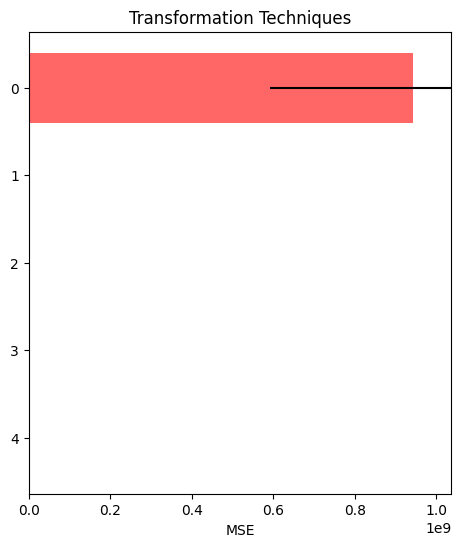

In [ ]:
from src.plots.transformator_mse import plot_mse

corrected = plot_mse(mses_dataset, stds_dataset, x_labels)

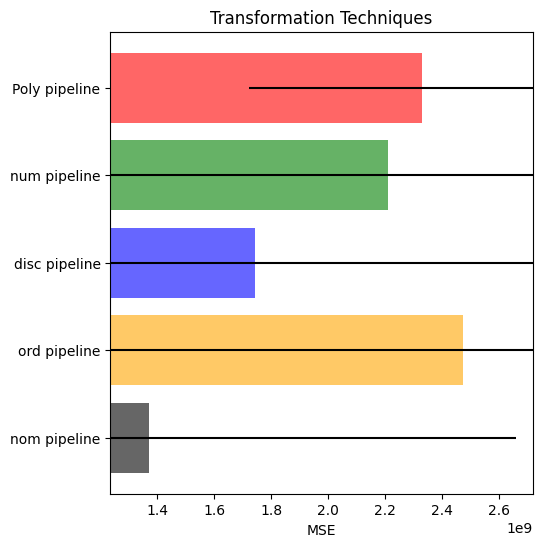

In [ ]:
from src.plots.transformator_mse import plot_mse

plot_mse(mses_dataset, stds_dataset, x_labels)